# Lane Finder Production Pipeline
## Outputs a map of our detection of the lane 
## Along with live calculations of lane curvature and car distance from center of lane

## Calibrate the camera lens

20


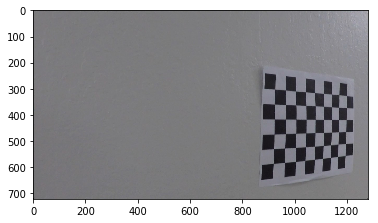

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt 
%matplotlib inline

# prep and set object and image points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

# array of images to calibrate
images = glob.glob('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

print(len(images))
test = plt.imread(images[6])
plt.imshow(test)

In [4]:
# loop through images to find and store chessboard corners and comparable blank images
for image in images:
    img = plt.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6))
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

(720, 1280, 3)


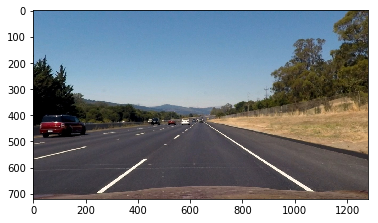

In [5]:
# prep image for testing
img = plt.imread('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg')

def undistort(image, objpoints, imgpoints):

    # compare where corners are in image to a blank to get calibration matrix and coefficients (weights)
    ret, mtx, coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]), None, None)

    # use the matrix and weights to undistort the raw image input given to the pipeline
    undst = cv2.undistort(image, mtx, coeffs, None, mtx)
    print(undst.shape)
    plt.imshow(undst)

    #bottom_left = [200, undst.shape[0]]
    #bottom_right = [1125, undst.shape[0]]
    #top_left = [580, 450]
    #top_right = [700, 450]
    #plt.plot(bottom_left[0], bottom_left[1], '.')
    #plt.plot(bottom_right[0], bottom_right[1], '.')
    #plt.plot(top_left[0], top_left[1], '.')
    #plt.plot(top_right[0], top_right[1], '.')

    return undst

undst = undistort(img, objpoints, imgpoints)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/undistorted_image.jpg', undst)
plt.imshow(undst)

## Now with an undistorted view of the read we'll change the view to a top down "birds-eye-view"

(720, 1280, 3)


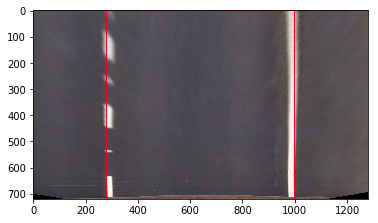

In [6]:
def top_down_warp(undst):
    # 4 corners of the lane
    bottom_left = [200, undst.shape[0]]
    bottom_right = [1125, undst.shape[0]]
    top_left = [594, 450]
    top_right = [690, 450]
    src = np.float32([bottom_left, bottom_right, top_left, top_right])
    # those 4 corners mapped top down
    bottom_left_dst = [280, undst.shape[0]]
    bottom_right_dst = [1000, undst.shape[0]]
    top_left_dst = [280, 0]
    top_right_dst = [1000, 0]
    dst = np.float32([bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undst, M, (undst.shape[1], undst.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
top_down, perspective_M, Minv = top_down_warp(undst)
cv2.rectangle(top_down,(280, undst.shape[0]),
        (1000,0),(255,0,0), 2)
print(top_down.shape)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/top_down.jpg', undst)
plt.imshow(top_down)

## From this 2-D view we can better see and calculate the curve of the road

### To start we'll set gradient and color thresholds to best detect the lane lines

Text(0.5,1,'Magnitude(XY) Grad. Filter')

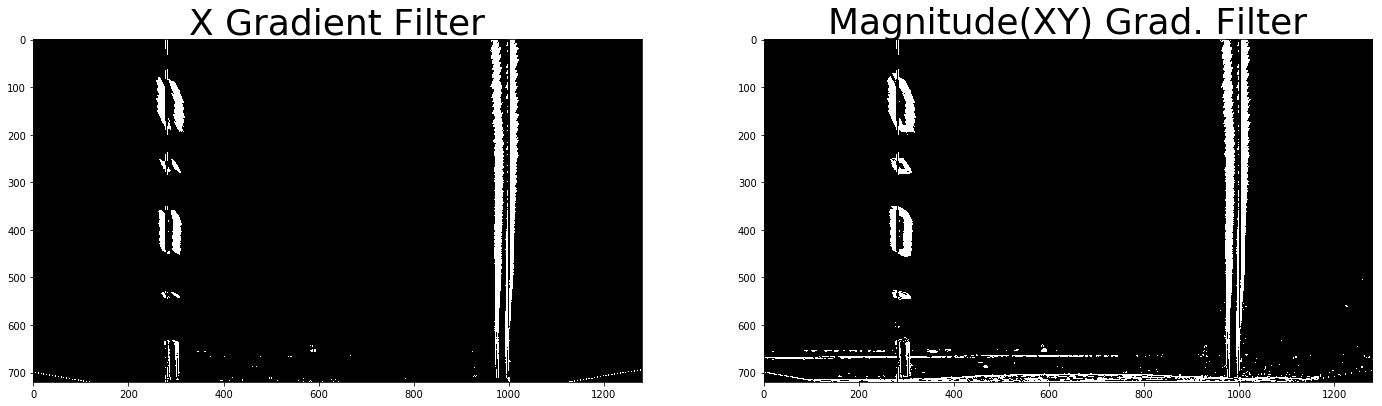

In [7]:
# Sobel gradient threshold
# Magnitude threshold
# HSL color threshold
def grad_threshold(img, orient='x', sobel_kernel=3, thresh=(30,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    elif (orient == 'xy'):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(sobelx**2 + sobely**2)
    else:
        return str('orient options: x, y, xy')
    abs_sobel = np.absolute(sobel)
    sbinary = np.zeros_like(abs_sobel)
    sbinary[(abs_sobel > thresh[0]) & (abs_sobel < thresh[1])] = 1
    return sbinary
sobelx_img = grad_threshold(top_down, orient='x')
sobelxy_img = grad_threshold(top_down, orient='xy')
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(sobelx_img, cmap='gray')
ax1.set_title('X Gradient Filter', fontsize=36)
ax2.imshow(sobelxy_img, cmap='gray')
ax2.set_title('Magnitude(XY) Grad. Filter', fontsize=36)

## The X gradient looks pretty good. We can clearly see the lane lines with little noise elsewhere
## Still let's see if we can't do better with HSL color thresholding

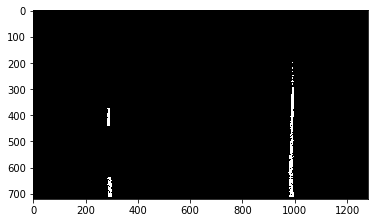

In [8]:
def color_filter(image, thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_filter = hls[:,:,0]
    l_filter = hls[:,:,1]
    s_filter = hls[:,:,2]
    sbinary = np.zeros_like(s_filter)
    sbinary[(s_filter > thresh[0]) & (s_filter < thresh[1])] = 1
    return sbinary

s_filter_img = color_filter(top_down)
plt.imshow(s_filter_img, cmap='gray')

## From testing saturation looks to be the most accurate and least noisy across changes in shadows and lane colors
## We'll use the sobel x gradient and saturation levels as our main lane detection thresholds

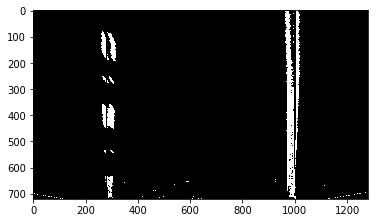

In [9]:
def combined_thresholds(top_down_img):
    sobelx_img = grad_threshold(top_down_img, orient='x')
    s_filter_img = color_filter(top_down_img)
    combined_binary = np.zeros_like(s_filter_img)
    combined_binary[(sobelx_img == 1) | (s_filter_img == 1)] = 1
    return combined_binary
combined_binary = combined_thresholds(top_down)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/combined_threshold.jpg', undst)
plt.imshow(combined_binary, cmap='gray')

## Now we can calculate where the lines are based on where our thresholds are activated (a '1' in our binary image)
## Here's where those activations occurred along the x-axis

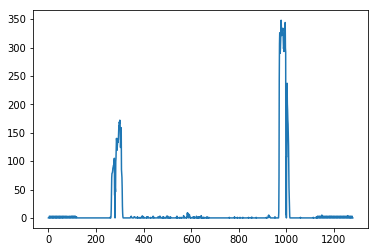

In [10]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## We'll use a sliding window algorithm to find and map the coordinates of those activations

left_line_coeffs: [1.55417803e-05 1.92261272e-03 2.86376400e+02]
left_line_coeffs_m: [4.73180602e-05 2.43897157e-04 1.51370383e+00]


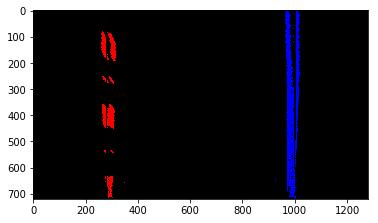

In [11]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def find_lane_pixels(combined_binary):
    # Create an output image to draw on and visualize windows
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))
    # Starting point for the left and right lines
    histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(combined_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Line fit coefficients in pixel and meter values
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Now in meters
    left_fitx_m = left_fit_m[0]*ploty**2 + left_fit_m[1]*ploty + left_fit_m[2]
    right_fitx_m = right_fit_m[0]*ploty**2 + right_fit_m[1]*ploty + right_fit_m[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right equations of the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx, left_fitx_m, right_fitx_m


windowed_img, ploty, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx, left_fitx_m, right_fitx_m = fit_polynomial(combined_binary)
print("left_line_coeffs:", left_fit)
print("left_line_coeffs_m:", left_fit_m)
plt.imshow(windowed_img)

[1.55417803e-05 1.92261272e-03 2.86376400e+02]
[-3.73796324e-05  1.51284898e-02  9.89784426e+02]


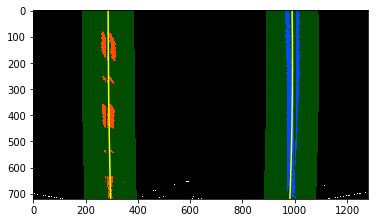

In [12]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([-3.15438715e-05,  1.32907859e-02,  2.12725998e+02])
#right_fit = np.array([ 6.68749175e-05, -4.47663172e-02,  1.10149602e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial for line coefficients 
    left_fit_c = np.polyfit(lefty, leftx, 2)
    right_fit_c = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit_c, right_fit_c

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy 
                    + right_fit[2]) - margin) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_c, right_fit_c = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result, left_fitx, right_fitx, ploty, left_fit_c, right_fit_c

result, left_fitx, right_fitx, ploty, left_fit_c, right_fit_c = search_around_poly(combined_binary)
print(left_fit)
print(right_fit)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/lane_lines_polynomials.jpg', result)
plt.imshow(result)

## Now that we have our equation of the line for both lane lines we can use that to measure curvature of the road
## We'll use the radius of curvature formula to do this

In [13]:
def measure_curve_rad(left_fit_c, right_fit_c, ploty):
    y_eval = np.max(ploty)

    # r_curve = ((1+(2Ay+B)^2)^3/2) / 2A
    left_curve_rad = (1+(2*left_fit_c[0]*y_eval+left_fit_c[1])**2)**1.5 / np.absolute(2*left_fit_c[0])
    right_curve_rad = (1 + (2*right_fit_c[0]*y_eval + right_fit_c[1])**2)**1.5 / np.absolute(2*right_fit_c[0])
    return left_curve_rad, right_curve_rad
left_curve_rad, right_curve_rad = measure_curve_rad(left_fit_c, right_fit_c, ploty)
print(left_fit_c)
print(left_curve_rad, right_curve_rad)

[1.12923612e-05 4.39762158e-03 2.86116420e+02]
44306.00544216148 13406.21111004498


In [14]:
def update_poly(binary_warped, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ym_per_px = 30/720
    xm_per_px = 3.7/700

    current_leftx = np.array([280 + left_fit[0]*y**2+left_fit[1]*y+left_fit[2] + 
                    np.random.randint(-50, high=51) for y in ploty])
    current_rightx = np.array([1000 + right_fit[0]*y**2+right_fit[1]*y+right_fit[2] + 
                    np.random.randint(-50, high=51) for y in ploty])

    current_left_fit = np.polyfit(ploty, current_leftx, 2)
    current_right_fit = np.polyfit(ploty, current_rightx, 2)

    # in meters for updating radius of curvature
    ploty_m = ploty*ym_per_px
    current_leftx_m = current_leftx*xm_per_px
    current_rightx_m = current_rightx*xm_per_px

    current_left_fit_m = np.polyfit(ploty_m, current_leftx_m, 2)
    current_right_fit_m = np.polyfit(ploty_m, current_rightx_m, 2)
    
    return ploty, current_left_fit, current_right_fit, current_left_fit_m, current_right_fit_m, 

ploty, left_fit, right_fit, left_fit_m, right_fit_m = update_poly(combined_binary, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx)
print(left_fit)
print(len(right_fit))
print(len(left_fit_m))
print(right_fit_m)

[ 4.39024201e-05 -1.46712906e-02  5.65009728e+02]
3
3
[ 6.16042620e-05 -2.64789800e-03  1.05352602e+01]


## Finally to get a real world accurate measure of the curve of the lane we need to run our measurement of the curve equation again with x and y values in meters instead of pixels

In [15]:
def measure_real_curve_rad(left_fit_m, right_fit_m):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
  
    y_eval = np.max(ploty)

    # r_curve = ((1+(2Ay+B)^2)^3/2) / 2A
    left_curve_rad  = (1+(2*left_fit_m[0]*(y_eval*ym_per_pix)+left_fit_m[1])**2)**1.5 / np.absolute(2*left_fit_m[0])
    right_curve_rad = (1+(2*right_fit_m[0]*(y_eval*ym_per_pix)+right_fit_m[1])**2)**1.5 / np.absolute(2*right_fit_m[0])
    return left_curve_rad, right_curve_rad
left_curve_rad, right_curve_rad = measure_real_curve_rad(left_fit_m, right_fit_m)
print(left_curve_rad, right_curve_rad) 

3740.9335541366245 8116.334814309927


## BONUS We're also going to keep track of the cars position from the center of the lane. Did you know self driving cars drive on avg more centered in the lane than humans!? 

In [16]:
def measure_off_center(image, left_fit_m, right_fit_m):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    y_in_m = image.shape[0] * ym_per_pix
    
    center_of_lane = image.shape[1] / 2 * xm_per_pix

    left_x_m = y_in_m**2*left_fit_m[0] + y_in_m*left_fit_m[1] + left_fit_m[2]
    right_x_m = y_in_m**2*right_fit_m[0] + y_in_m*right_fit_m[1] + right_fit_m[2]
    car_from_center = (left_x_m + right_x_m) / 2
    off_center = center_of_lane - car_from_center
    return round(off_center, 3)
result = measure_off_center(img, left_fit_m, right_fit_m)
print(result)

-3.398


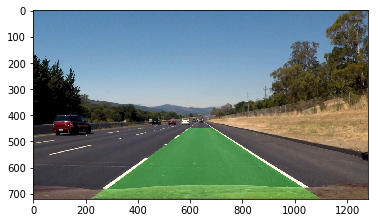

In [17]:
def draw_lane(combined_binary, undst, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undst.shape[1], undst.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    return result
result = draw_lane(combined_binary, img, left_fitx, right_fitx, ploty, Minv)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/straight_line_test.jpg', undst)
plt.imshow(result)

## All our helper functions looks to be functioning properly
## Now we can put it all together into one pipeline 
## And track how the values change over time with a class

In [18]:
# Class to store and keep track of most up to date calculation numbers
class Line_live: 
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [19]:
test1_img = plt.imread('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
test2_img = plt.imread('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/test_images/test2.jpg')

In [20]:
def pipeline(image):
    # calibrate
    undst_img = undistort(image, objpoints, imgpoints)
    top_down_img, perspective_M, Minv = top_down_warp(undst_img)
    combined_thresh_img = combined_thresholds(top_down_img)

    # calculate
    left_lane_live = Line_live()
    right_lane_live = Line_live()
    if left_lane_live.detected or right_lane_live.detected == False:
        window_fit_img, ploty, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx, left_fitx_m,                    right_fitx_m = fit_polynomial(combined_thresh_img)
    else:
        ploty, left_fitx, right_fitx, left_fitx_m, right_fitx_m = update_poly(combined_thresh_img,left_fit, right_fit,                                                                                   left_fit_m, right_fit_m, left_lane_live.bestx, right_lane_live.bestx)

    # store
    if len(left_fit) and len(right_fit) > 0: 
        left_lane_live.detected = True
        right_lane_live.detected = True

        if left_lane_live.current_fit is None:
            left_lane_live.current_fit = left_fit
        else:
            left_lane_live.diffs = left_lane_live.current_fit - left_fit 
        if right_lane_live.current_fit is None:
            right_lane_live.current_fit = right_fit
        else:
            right_lane_live.diffs = right_lane_live.current_fit - right_fit
        if left_lane_live.bestx is None:
            left_lane_live.bestx = left_fitx
        else:
            left_lane_live.bestx = (np.array(left_lane_live.bestx) + np.array(left_fitx)) / 2 #smooth fix
        if right_lane_live.bestx is None:
            right_lane_live.bestx = right_fitx
        else:
            right_lane_live.bestx = (np.array(right_lane_live.bestx) + np.array(right_fitx)) / 2

    left_curve_rad, right_curve_rad = measure_real_curve_rad(left_fit_m, right_fit_m)
    combined_rad = np.sqrt(left_curve_rad**2 + right_curve_rad**2)
    left_lane_live.radius_of_curvature = combined_rad
    right_lane_live.radius_of_curvature = combined_rad
    off_center = measure_off_center(image, left_fit_m, right_fit_m)
    left_lane_live.line_base_pos = off_center
    right_lane_live.line_base_pos = off_center

    # show
    lane = draw_lane(combined_thresh_img, undst_img, left_fitx, right_fitx, ploty, Minv)
    curve_img = cv2.putText(lane, 'Radius of curvature: ' + str(round(combined_rad)) + 'm', (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    full_data_img = cv2.putText(lane, 'Distance from center: ' + str(off_center) + 'm', (30,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    return full_data_img

(720, 1280, 3)


True

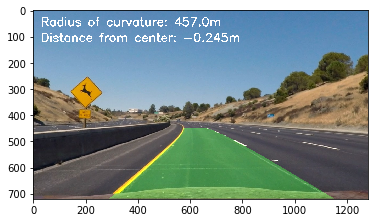

In [21]:
result = pipeline(test2_img)
plt.imshow(result)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/output_images/output_photo.jpg', result)

one](720, 1280, 3)
t: 100%|██████████| 1260/1260 [21:59<00:00,  1.02s/it, now=None](720, 1280, 3)
(720, 1280, 3)
Moviepy - Done !
Moviepy - video ready /Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/project_video_output_test.mp4


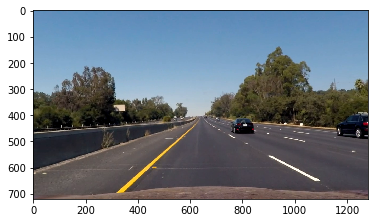

In [26]:
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_input = VideoFileClip('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/project_video.mp4')
challenge_video_input = VideoFileClip('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/challenge_video.mp4')
harder_input = VideoFileClip('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/harder_challenge_video.mp4')

output = '/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/project_video_output_test.mp4'
challenge_output = '/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/challenge_video_output.mp4'
harder_output = '/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/advanced_lane_lines_project/CarND-Advanced-Lane-Lines/harder_output.mp4'

proccessed_output = video_input.fl_image(pipeline)
proccessed_output.write_videofile(output, audio=False)
#proccessed_challenge = challenge_video_input.fl_image(pipeline)
#proccessed_challenge.write_videofile(challenge_output, audio=False)
#harder_output = harder_input.fl_image(pipeline)
#harder_output.write_videofile(harder_output, audio=False)